<a href="https://colab.research.google.com/github/Mr-Petrov-S/a-b-test-for-app/blob/main/A_B_test_fonts_in_the_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект изменение шрифта в мобильном приложении. А/Б тест.

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.   

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?    

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.    

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.  

#### Описание данных
Каждая запись в логе — это действие пользователя, или событие.  
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

#### Посмотрим общую информацию о данных

In [ ]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats as st
import seaborn as sb
from plotly import graph_objects as go
from google.colab import drive

In [ ]:
# подключаем Google Drive
drive.mount('/content/drive')

# Путь к файлу на Google Drive
file_path = '/content/drive/My Drive/Data/logs_exp.csv'

# загружаем датасет
df = pd.read_csv(file_path, sep='\t')

Mounted at /content/drive


In [ ]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Нам дана таблица в которой 244 126 строк и 4 столбца. Названия столбцов мы поменяем для удобства. Дата представлена в timestamp, нам понадобится изменить тип данных. На первый взгляд пропусков нет, перейдем к более подробному рассмотрению.

#### Предобработка данных
- Заменим названия столбцов на более удобные;
- Проверим пропуски и типы данных;
- Добавим столбец даты и времени, а также отдельный столбец дат;

In [ ]:
# проверяем пропуски
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [ ]:
# поиск дубликатов
df.duplicated().sum()

413

In [ ]:
# смотрим дубликаты подробнее, чтобы убедится что это действительно они
df[df.duplicated(keep=False)].head(20)

,EventName,DeviceIDHash,EventTimestamp,ExpId
452,MainScreenAppear,5613408041324010552,1564474784,248
453,MainScreenAppear,5613408041324010552,1564474784,248
2348,CartScreenAppear,1694940645335807244,1564609899,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3572,MainScreenAppear,434103746454591587,1564628377,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4075,MainScreenAppear,3761373764179762633,1564631266,247
4076,MainScreenAppear,3761373764179762633,1564631266,247
4801,MainScreenAppear,2835328739789306622,1564634641,248
4803,MainScreenAppear,2835328739789306622,1564634641,248


In [ ]:
# удаляем дубликаты
df.drop_duplicates(inplace=True)

In [ ]:
# переименовываем колонки
df = df.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_time', 'ExpId':'group_id'})

In [ ]:
# создаем столбцы даты и времени
df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
df['event_date'] = df['event_time'].dt.date

In [ ]:
df.head()

,event_name,user_id,event_time,group_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [ ]:
# смотрим распределение пользователей по группам
df['group_id'].value_counts()

group_id
248    85582
246    80181
247    77950
Name: count, dtype: int64

In [ ]:
# смотрим распределение по действиям
df['event_name'].value_counts()

event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64

In [ ]:
# смотрим число уникальных пользователей
df['user_id'].nunique()

7551

**Вывод после предобработки:**  
При более детальном рассмотрении было найдено 413 дубликатов, которые были удалены нами. В наших даных 7551 уникальных пользователей, разбитых на 3 группы: 246, 247 и 248. Распределение всех активностей и событй по группам немного неравномерное. Для группы 248 - 85 тысяч наблюдений, для 247 - 77 тысяч, для 246 - 80 тысяч. Пропусков в данных нет. Нами переименованы столбцы датафрейма, для удобства, а также добавлен один столбец.  
   
Новые названия столбцов с описанием:
- event_name - название активности или события;
- user_id - уникальный идентификатор пользователя;
- event_time - дата и время произошедшего события;
- group_id - группа пользователя совершившего событие;
- event_date - дата произошедшего события, без времени.

#### Изучение данных

Задачи от бизнес заказчика:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у нас одинаково полные данные за весь период?
- Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?
- Много ли событий и пользователей мы потеряем, отбросив старые данные?
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

**Проверим что все пользователи принадлежат только к одной группе**

In [ ]:
# группируем по пользователям и проверяем что каждый принадлежит только к одной уникальной группе
df.groupby('user_id', as_index=False).agg({'group_id':'nunique'}).sort_values(by='group_id', ascending=False)

,user_id,group_id
0,6888746892508752,1
5030,6207768971558512760,1
5042,6217807653094995999,1
5041,6217295124800833842,1
5040,6216080220799726690,1
...,...,...
2513,3175239243679501019,1
2512,3171891164497446149,1
2511,3171454373076660766,1
2510,3170212200647575044,1


**Сколько всего событий в логе?**

In [ ]:
# подсчет уникальных событий
df['event_name'].value_counts()

event_name
MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: count, dtype: int64

В логе 5 уникальных событий.
- MainScreenAppear - открыт главный экран
- OffersScreenAppear - открыт экран с товарами
- CartScreenAppear - открыт экран корзины
- PaymentScreenSuccessful - открыт экран успешной оплаты
- Tutorial - открыт экран подсказки

**Сколько всего пользователей в логе?**

In [ ]:
# подсчет уникальных пользователей
df['user_id'].nunique()

7551

В логе 7551 уникальный пользователь.

**Сколько в среднем событий приходится на пользователя?**

In [ ]:
# считаем окгругленное среднее количество действий на каждого пользователя
df.groupby('user_id').agg({'event_name':'count'}).mean().round()

event_name    32.0
dtype: float64

In [ ]:
# смотрим пользователей с максимальным кол-вом действий
df.groupby('user_id', as_index=False).agg({'event_name':'count'}).sort_values(by='event_name', ascending=False).head(10)

,user_id,event_name
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
2641,3337471580007169353,1186
6294,7738058666231999878,888
822,1055544042902443290,854
3801,4713748699910253089,824
6617,8118046800480174342,755


In [ ]:
# смотрим пользователей с минимальным кол-вом действий
df.groupby('user_id', as_index=False).agg({'event_name':'count'}).sort_values(by='event_name', ascending=True).head(10)

,user_id,event_name
0,6888746892508752,1
3224,4033444713489412517,1
6489,7962370797737085275,1
480,636273053050387468,1
1529,1918918598819548986,1
131,176222176030858478,1
4611,5712952270342213514,1
3829,4738501680785639562,1
5817,7191374641631621327,1
950,1223708690315846789,1


В среднем на пользователя приходится 32 события. Максимальное количество событий на пользователя - 2307, минимальное - одно событие.

**Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у нас одинаково полные данные за весь период?**

In [ ]:
# находим минимальную дату в данных
df['event_date'].min()

datetime.date(2019, 7, 25)

In [ ]:
# находим максимальную дату в данных
df['event_date'].max()

datetime.date(2019, 8, 7)

In [ ]:
# готовим данные для графика
group = df.groupby(['event_date', 'group_id'], as_index=False).agg({'event_name':'count'})

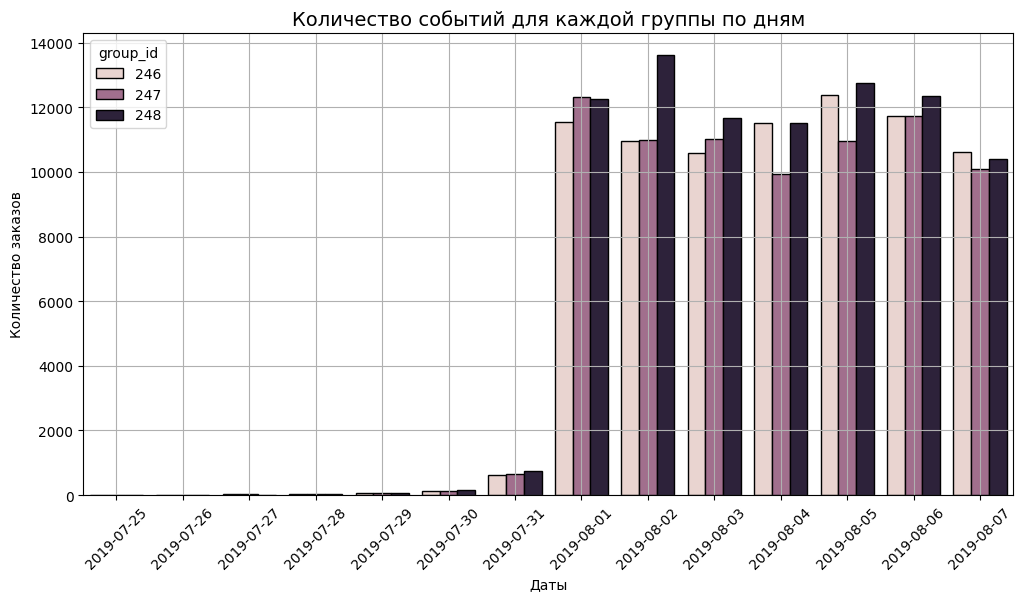

In [ ]:
# строим график
plt.figure(figsize=(12, 6), dpi=100)

sb.barplot(x = 'event_date', y = 'event_name', hue = "group_id", data = group, edgecolor='black')

sb.set()

sb.set_style('darkgrid')

plt.grid(True)

plt.title('Количество событий для каждой группы по дням', fontsize=14, color='black')

plt.xlabel('Даты')

plt.ylabel('Количество заказов')

plt.xticks(rotation=45)

plt.show()

Минимальная дата в наших данных - 25.07.2019 года, максимальная - 07.08.2019 года. На графике вы видим значительную разницу между данныи до 31.07.2019 и данными после этой даты. До 31.07.2023 количество событий по группам держалось до 500, показывая небольшой рост с 29.07. по 31.07. Начиная с 01.08. количество событий резко возросло и держится в диапазоне от 10 до 14 тысяч, до конца наблюдений.

**Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?**

In [ ]:
# посмотрим на количество событий по дням подробнее
df.groupby('event_date').agg({'event_name':'count'})

,event_name
event_date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


При количественном рассмотрении распределения событий по датам, мы видим что разумно будет взять данные с 01.08. Так как 31-го июля мы имеем 2030 событий, а 1-го августа уже 36 тысяч.

In [ ]:
# собираем в отдельный датафрейм данные за нужнный нам период
df_filtered = df[df['event_date'] > pd.to_datetime('2019-07-31').date()]

In [ ]:
# проверяем созданный датафрейм
df_filtered.groupby('event_date').agg({'event_name':'count'})

,event_name
event_date,
2019-08-01,36141
2019-08-02,35554
2019-08-03,33282
2019-08-04,32968
2019-08-05,36058
2019-08-06,35788
2019-08-07,31096


По итогу мы отбросили все имеющиеся у нас данные за июль, с 25-го по 31-е число. Таким образом мы имеем данные за 7 дней августа.

**Много ли событий и пользователей мы потеряли, отбросив старые данные?**

In [ ]:
# вычитаем размеры датафреймов
df.shape[0]-df_filtered.shape[0]

2826

In [ ]:
# считаем сколько процентов данных мы потеряли
(df.shape[0]-df_filtered.shape[0])/df.shape[0]*100

1.159560630741897

In [ ]:
# количество уникальных пользователей в отфильтрованном датасете
df_filtered['user_id'].nunique()

7534

In [ ]:
# сколько пользователей мы потеряли
df['user_id'].nunique()-df_filtered['user_id'].nunique()

17

In [ ]:
# потери пользователей в процентном отношении
(df['user_id'].nunique()-df_filtered['user_id'].nunique())/df['user_id'].nunique()*100

0.22513574361011784

После очистки данных, мы потеряли 17 пользователей, теперь их 7534. В части событий мы потеряли 2826 записей, что является чуть более чем одним процентом от общего количества данных.

**Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.**

In [ ]:
# группируем и считаем уникальных пользователей
df_filtered.groupby('group_id').agg({'user_id':'nunique'})

,user_id
group_id,
246,2484
247,2513
248,2537


Мы распологаем почти равным количеством уникальных пользователей во всех трех группах в отфильтрованных данных.

#### Изучение воронки событий


Задачи от бизнес заказчика:
- Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.
- Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.
- Посчитаем долю пользователей, которые хоть раз совершали событие.
- В каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?
- Посчитаем по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряется больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

**Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.**

In [ ]:
df_filtered['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

В логе 5 уникальных событий.

- MainScreenAppear - открыт главный экран
- OffersScreenAppear - открыт экран с товарами
- CartScreenAppear - открыт экран корзины
- PaymentScreenSuccessful - открыт экран успешной оплаты
- Tutorial - открыт экран подсказки

В данном списке они отсортированы по частоте их встречаемости в наших данных. Чаще всего пользователи открывают главный экран, после идет экран с товарами, далее корзина, после экран успешной оплаты. В целом это выглядит как воронка. Не совсем понятно событие Tutorial, о каком туториале идет речь? Инструкции о работе с системой или о том как будет осуществлена доставка?

**Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.**

In [ ]:
# группируем по событиям и считаем уникальных пользователей
df_filtered.groupby('event_name', as_index=False).agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


- Открыт главный экран - 7419 пользователей
- Открыт экран с заказом - 4593 пользователя
- Открыт экран корзины - 3734 пользователя
- Открыт экран успешной оплаты - 3539 пользователей
- Открыт экран подсказки - 840 пользователей

**Посчитаем долю пользователей, которые хоть раз совершали событие.**

In [ ]:
# к предудущей группировке добавим отношение с общим кол-вом пользователей
result = df_filtered.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
result['share_total'] = (result['user_id']/df_filtered['user_id'].nunique()).round(2)
result

,event_name,user_id,share_total
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


- Открыт главный экран - 98 % пользователей
- Открыт экран с заказом - 61 % пользователя
- Открыт экран корзины - 50 % пользователя
- Открыт экран успешной оплаты - 47 % пользователей
- Открыт экран подсказки - 11 % пользователей

**В каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?**

Я думаю что события распологаются в том же порядке в котором мы наблюдаем их в ячейке выше, кроме туториала. Первым пользователь видит главную страницу, следом страницу заказа, после страницу корзины, далее страницу успешной оплаты. Вероятно есть путь в котором пользователь переходит на туториал, не разобравшись с каким-то из этапов. То есть переход в туториал может быть на любом этапе, включая последний (если пользователю не понятно как происходит доставка и он хочет почитать об этом в туториале).

**Посчитаем по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B**

In [ ]:
# убираем туториал
result = result.loc[result['event_name'] != 'Tutorial'].copy()
# сдвигаем количество пользователей на один вниз
result['share_of_users'] = result['user_id'].shift(1)
# делим количество пользователей предыдущего шага на следующий, Nan заполняем максимальным значением кол-ва пользователей
result['share_of_users'] = result['user_id'].div(result['share_of_users'], fill_value=result['user_id'].max()).round(2)
result

,event_name,user_id,share_total,share_of_users
0,MainScreenAppear,7419,0.98,1.00
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95


In [ ]:
# рисуем воронку
fig = go.Figure(go.Funnel(
    y = result['event_name'],
    x = result['share_of_users'],

    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}))

fig.show()

- Открыт главный экран - 100 % пользователей, начало воронки.
- Открыт экран с заказом - на этот этап переходит 62 % из тех кто был на главной странице.
- Открыт экран корзины - 81 % из тех кто взаиможействовал с экраном заказа переходит в корзину.
- Открыт экран успешной оплаты - 95 % открыших страницу корзины оплачивают заказ.   

Экран подсказки рассматривать не будем, так как нет уверенности что он часть этой воронки

**На каком шаге теряем больше всего пользователей?**

Больше всего пользователей мы теряем на этапе перехода от главной страницы к странице с заказом. 38 % пользователей теряются на этом шаге. Следом с показателем 20-ти процентной потери идет переход от страницы заказа к корзине. На этапе оплаты отваливается 5 % пользователей, это лучший показатель в нашей воронке.

**Какая доля пользователей доходит от первого события до оплаты?**

От просмотра главной страницы до оплаты доходит 47 % наших пользователей.

#### Проведение эксперпимента и изучение его результатов

**Задача от бизнес-заказчика:**

- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

**Сколько пользователей в каждой экспериментальной группе?**

In [ ]:
# группируем по id группы и считаем уникальное кол-во пользователей
df_filtered.groupby('group_id').agg({'user_id':'nunique'})

,user_id
group_id,
246,2484
247,2513
248,2537


В группе 246 - 2484 пользователя, в группе 247 - 2513 пользователей, в группе 248 - 2537 пользователей.

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

Мы подошли к проведению непосредственно экспериментов для контрольных групп и тестовой группы, которая получила изменения в дизайне. Нам требуется проверить есть ли разница между долями в тестовых группах, чтобы убедится что наше разбиение по группам работает и они показывают примерно одинаковое прохождение воронки. После этого мы можем приступить к аналогичной проверке уже между контрольной группой со страрым отображение шрифтов и тестовой группой которая взаимодействала с измененными шрифтами. Для такой проверки нам подойдет Z-тест.

Сформулируем наши гипотезы:
- Н0: Между долями пользователей нет существенной разницы
- Н1: Между долями пользователей есть существенная разница

Так как все наши проверки одноообразные, мы можем использовать эти гипотезы без изменения для всех наших проверок. В качестве значения уровня статистической значимости примем 5%, так как наши данные не являются научными и мы можем быть менее строги мы берем 5% а не 1%.

In [ ]:
# задаем уровень статистической значимости
alpha = 0.05

# число наблюдений в группах
result_trials = df_filtered.groupby('group_id').agg({'user_id':'nunique'}).reset_index()
trials = np.array([result_trials[result_trials['group_id'] == 246]['user_id'], result_trials[result_trials['group_id'] == 247]['user_id']])

# число успехов в группе
result_successes = df_filtered.groupby(['group_id', 'event_name']).agg({'user_id':'nunique'}).reset_index()
successes = np.array([
    result_successes[(result_successes['group_id'] == 246) &
                     (result_successes['event_name'] == 'PaymentScreenSuccessful')]['user_id'],
    result_successes[(result_successes['group_id'] == 247) &
                     (result_successes['event_name'] == 'PaymentScreenSuccessful')]['user_id']
])

#  пропорция успехов в группах
p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

# объединенная пропорция успеха
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По итогам проведенного Z-теста, мы видим что между группами нет статистической разницы.

**Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?**

In [ ]:
def z_proportion(group1, group2, event_group, group_for_sum=None):
    # задаем уровень статистической значимости
    alpha = 0.05

    # число наблюдений в группах
    result_trials = df_filtered.groupby('group_id').agg({'user_id':'nunique'}).reset_index()
    trials = np.array([result_trials[result_trials['group_id'] == group1]['user_id'],
                       result_trials[result_trials['group_id'] == group2]['user_id']
    ])

    # число успехов в группе
    result_successes = df_filtered.groupby(['group_id', 'event_name']).agg({'user_id':'nunique'}).reset_index()
    successes = np.array([
        result_successes[(result_successes['group_id'] == group1) &
                         (result_successes['event_name'] == event_group)]['user_id'],
        result_successes[(result_successes['group_id'] == group2) &
                         (result_successes['event_name'] == event_group)]['user_id']
    ])

    print('Проверка для ', event_group)

    if group_for_sum is None:
        #  пропорция успехов в группах
        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]

        # объединенная пропорция успеха
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )
    else:
        trials_sum = np.append(trials, result_trials[result_trials['group_id'] == group_for_sum]['user_id'])
        successes_sum = np.append(successes, result_successes[(result_successes['group_id'] == group_for_sum) &
                                 (result_successes['event_name'] == event_group)]['user_id'])
        #  пропорция успехов в группах
        p1 = (successes_sum[0]+successes_sum[2])/(trials_sum[0]+trials_sum[2])
        p2 = successes_sum[1]/trials_sum[1]

        # объединенная пропорция успеха
        p_combined = (successes_sum[0] + successes_sum[1] + successes_sum[2]) / (trials_sum[0] + trials_sum[1] + trials_sum[2])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/(trials_sum[0]+trials_sum[2]) + 1/trials_sum[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )

In [ ]:
z_proportion(246, 247, 'MainScreenAppear')

Проверка для  MainScreenAppear
p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_proportion(246, 247, 'OffersScreenAppear')

Проверка для  OffersScreenAppear
p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
z_proportion(246, 247, 'CartScreenAppear')

Проверка для  CartScreenAppear
p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Судя по тому что для всех событий нулевая гипотеза не отвергается, мы можем утверждать что наши группы равны, что в свою очередь значит что разбиение на группы работает корректно.

**Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

In [ ]:
# вызываем функцию в цикле
for name in result['event_name']:
    z_proportion(246, 248, name)

Проверка для  MainScreenAppear
p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  OffersScreenAppear
p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  CartScreenAppear
p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  PaymentScreenSuccessful
p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [ ]:
for name in result['event_name']:
    z_proportion(247, 248, name)

Проверка для  MainScreenAppear
p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  OffersScreenAppear
p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  CartScreenAppear
p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  PaymentScreenSuccessful
p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение каждой из контрольных групп с группой в которой был изменен шрифт, выдает нам результат об отсутствии различий в данных группах. Перейдем к сравнению с объединённой контрольной группой.

In [ ]:
for name in result['event_name']:
    z_proportion(246, 248, name, 247)

Проверка для  MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Проверка для  PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


***Мы получили аналогичные прошлым результаты при сравнении объединенной из двух тестовых группы и группы с измененным шрифтом. Z-тест показывает нам что нет статистически значимой разницы в прохождении по воронке пользователей с измененным шрифтом и пользователей со старой его версией. Таким образом мы можем говорить о том что повсеместное внедрение нового шрифта в нашем продукте не окажет пагубного вляиния на поведение пользователей и их конверсию.
Что касается наблюдаемых нами данных по воронке в целом, мы обнаружили потерю 38% пользователей в момент перехода от главной странциы к заказу. Нам нужно проеверить, есть вероятность что мы закупаем нецелевой трафик в 38% случаев или у нас есть проблема в интерфейсе, возможно пользовательский путь от главной страницы до заказа неочевиден, нам нужно больше исследований для улучшения этого показателя в нашей воронке.***

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

В качестве уровня статистической значимости мы выбрали 5 %. Так как это наиболее часто применяемый уровень в статистических исследованиях. Такой уровень достаточно низкий, чтобы защититься от ложно положительных результатов, но не такой строгий, чтобы быть недостижимым. Мы в сумме провели 16 тестов, при этом повышение уровня статистической значимости до 10 % в нашем случае не даст другого эффекта, судя по значениям p-value получаемым нами в ходе этих экспериментов. Чтобы получить результаты отличные от наших хотя бы в части экспериментов, придется принять в качестве уровня статистической значимости 25 %, что создает для более высокую вероятность ложноположительных результатов.